In [ ]:
%matplotlib inline

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

geotif_filename = 'brad_sample.tif' 

### Use rasterio to view geotif for reference.
Note that the coordinate system is roughly 0:8000 by 0:4000.

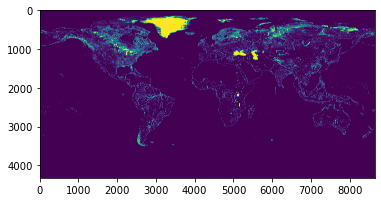

<AxesSubplot:>

In [4]:
import rasterio
from rasterio.plot import show
model_output = rasterio.open(geotif_filename, crs='EPSG:4326')
show(model_output)

### Open the tif with xarray.
Note, to use Dataset.rio.clip() below to clip, the Dataset needs the rio property. Currently, to get this to work, the geotiff is read, converted to a Dataset, written to NetCDF, and re-read using xarray. This tmp file stuff should not be required.

In [5]:
model_output = xr.open_rasterio(geotif_filename)
#model_output = model_output.rename({'x':'lon', 'y':'lat'})
model_output = model_output.to_dataset('band')
model_output = model_output.rename({1: 'feature'})
model_output.to_netcdf("model_ouput_tmp.nc", format="NETCDF4")

# Now re-read the netcdf.
model_output = xr.open_dataset('model_ouput_tmp.nc',decode_coords="all")
model_output.close()
model_output = model_output.rio.write_crs(4326)
# Drop time variables; for some reason clipping these is problematic...
#model_output = model_output[['harvested_area','harvest','production']]
model_output

<xarray.Dataset>
Dimensions:      (y: 4320, x: 8640)
Coordinates:
  * y            (y) float64 0.5 1.5 2.5 3.5 ... 4.318e+03 4.318e+03 4.32e+03
  * x            (x) float64 0.5 1.5 2.5 3.5 ... 8.638e+03 8.638e+03 8.64e+03
    spatial_ref  int64 0
Data variables:
    feature      (y, x) uint32 ...
Attributes:
    transform:   [1. 0. 0. 0. 1. 0.]
    res:         [ 1. -1.]
    is_tiled:    0
    nodatavals:  nan
    scales:      1.0
    offsets:     0.0

### Leverage GADM to obtain geometries of countries of interest.

<AxesSubplot:>

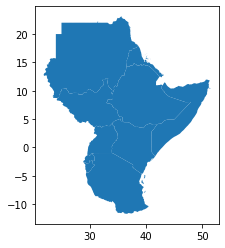

In [6]:
shapefile = 'gadm_0/gadm36_0.shp'
sf = gpd.read_file(shapefile)
countries = ['Ethiopia','South Sudan','Somalia','Kenya', 'Sudan', 'Eritrea', 'Somaliland', 
            'Uganda', 'Rwanda', 'Burundi', 'Tanzania']
countries_shp = sf[sf['NAME_0'].isin(countries)]
geo = countries_shp.to_crs(4326)
geo.plot()

### Clip the geotif Dataset to the East Africa geometry.

In [7]:
model_output_c = model_output.rio.clip(countries_shp.geometry)

### Compare the model output to the clipped model output.

#### Notes
1) The plotting used sets the origin at 0,0, so the image is upside-down.
2) The clipped version shows proper lon / lat coordinates; but, **how do we know clipping was correct when the coordinate systems are different? The model_output x,y probably needs to be converted to the correct lat/lon values.**


Text(0.5, 1.0, 'Model Output Clipped to Countries of Interest')

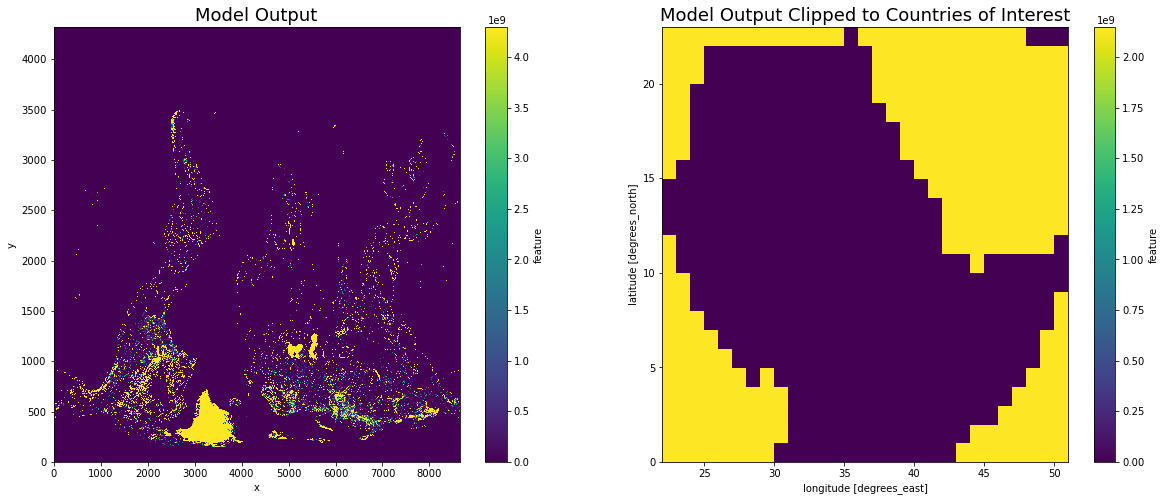

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 8))


model_output.feature.plot(ax=axes[0])
axes[0].set_title("Model Output", fontsize = 18)


model_output_c.feature.plot(ax=axes[1])
axes[1].set_title("Model Output Clipped to Countries of Interest", fontsize = 18)
